In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing


Импорт библиотек

In [3]:
ca = pd.read_excel(r'C:\Users\User\Documents\GitHub\Intensiv_3\Dataset\data\train.xlsx', engine='openpyxl')

Проверка данных (В нашем случае не нужно ничего заполнять)

In [4]:
ca.head(12)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


Дальше нужно переименовать столбцы для удобства

In [5]:
ca.rename(columns={'dt': 'date', 'Цена на арматуру': 'price'}, inplace=True)


ca['date'] = pd.to_datetime(ca['date'])
ca.set_index('date', inplace=True)


Проверяем

In [6]:
ca.head(12)

,price
date,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300
2015-02-09,30300
2015-02-16,30100
2015-02-23,29400
2015-03-02,29200


Устраняем небольшую ошибку

In [7]:
start_date = pd.to_datetime("2015-01-05")

ca['date'] = [start_date + pd.Timedelta(weeks=i) for i in range(len(ca))]

ca.set_index('date', inplace=True)

print(ca.head())

            price
date             
2015-01-05  32900
2015-01-12  32500
2015-01-19  32000
2015-01-26  30700
2015-02-02  30300


Модель Holt-Winters

c:\Users\User\Documents\GitHub\Intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\Documents\GitHub\Intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


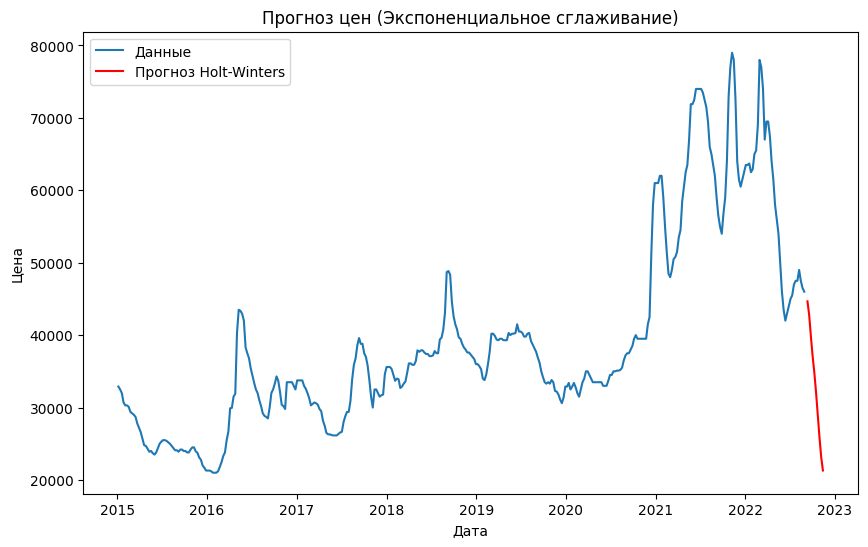

            Forecast
2022-09-11       NaN
2022-09-18       NaN
2022-09-25       NaN
2022-10-02       NaN
2022-10-09       NaN
2022-10-16       NaN
2022-10-23       NaN
2022-10-30       NaN
2022-11-06       NaN
2022-11-13       NaN


In [8]:
model_hw = ExponentialSmoothing(ca['price'], trend='add', seasonal='add', seasonal_periods=52)
model_hw_fit = model_hw.fit()

forecast_hw = model_hw_fit.forecast(steps=10)
plt.figure(figsize=(10, 6))
plt.plot(ca.index, ca['price'], label='Данные')
plt.plot(pd.date_range(ca.index[-1], periods=11, freq='W')[1:], forecast_hw, label='Прогноз Holt-Winters', color='red')
plt.title("Прогноз цен (Экспоненциальное сглаживание)")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.show()

forecast_df_hw = pd.DataFrame(forecast_hw, index=pd.date_range(ca.index[-1], periods=11, freq='W')[1:], columns=['Forecast'])
print(forecast_df_hw)

Ага! Обнаружены NaN. Пробуем вторую модель, уже линейную регрессию

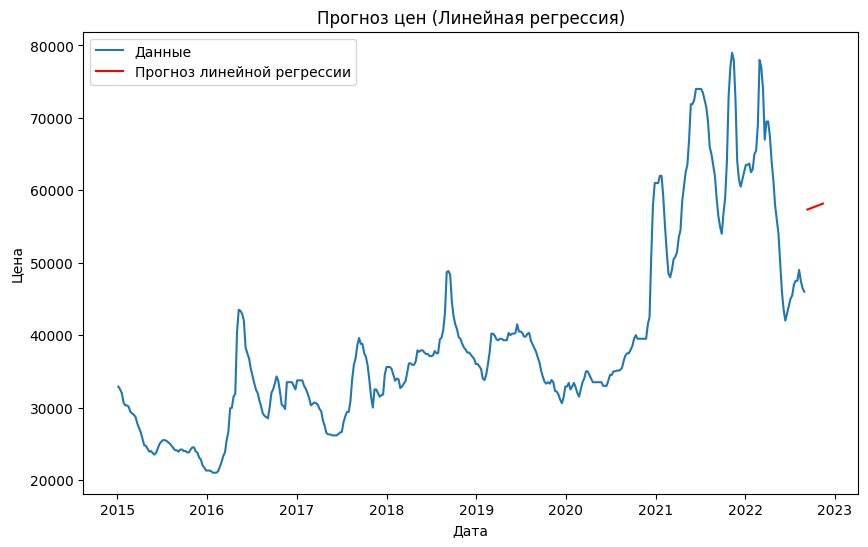

                Forecast
2022-09-11  57347.680075
2022-09-18  57438.045188
2022-09-25  57528.410300
2022-10-02  57618.775413
2022-10-09  57709.140526
2022-10-16  57799.505638
2022-10-23  57889.870751
2022-10-30  57980.235863
2022-11-06  58070.600976
2022-11-13  58160.966089


In [9]:
ca['week_num'] = np.arange(1, len(ca) + 1)

X = ca['week_num'].values.reshape(-1, 1)  
y = ca['price'].values 

model_lr = LinearRegression()
model_lr.fit(X, y)

future_weeks = np.arange(len(ca) + 1, len(ca) + 11).reshape(-1, 1)
forecast_lr = model_lr.predict(future_weeks)

plt.figure(figsize=(10, 6))
plt.plot(ca.index, ca['price'], label='Данные')
plt.plot(pd.date_range(ca.index[-1], periods=11, freq='W')[1:], forecast_lr, label='Прогноз линейной регрессии', color='red')
plt.title("Прогноз цен (Линейная регрессия)")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.show()

forecast_df_lr = pd.DataFrame(forecast_lr, index=pd.date_range(ca.index[-1], periods=11, freq='W')[1:], columns=['Forecast'])
print(forecast_df_lr)

Выглядит ОЧЕНЬ странно